In [95]:
import numpy as np
import torch
import torch.nn as nn
from mmaction.apis import init_recognizer
from mmaction.datasets import build_dataset, build_dataloader

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
import matplotlib.pyplot as plt

import psutil
import os
if not os.getcwd().endswith('mmaction2'):
    os.chdir('..')
os.getcwd()

'/data/hyogun/repos/haawron_mmaction2'

In [3]:
config = 'work_dirs/train_output/ek100/tsm/vanilla/P02/source-only/16279__vanilla_tsm_P02_source-only/0/20220326-202754/vanilla_tsm_ek100.py'
checkpoint = 'work_dirs/train_output/ek100/tsm/vanilla/P02/source-only/16279__vanilla_tsm_P02_source-only/0/20220326-202754/epoch_50.pth'
model = init_recognizer(config, checkpoint, device='cuda')

cfg = model.cfg
model.training, next(model.parameters()).is_cuda

Use load_from_local loader


(False, True)

In [4]:
from mmaction.core import OutputHook

def get_scores_and_features(model, x):
    outputs = ['backbone']
    with OutputHook(model, outputs=outputs, as_tensor=True) as h:
        with torch.no_grad():
            scores = model(x.cuda(), return_loss=False)[0]
        returned_features = h.layer_outputs if outputs else None
    consensus = gap_and_consensus(model, returned_features['backbone'])
    return scores, consensus

gap = nn.AdaptiveAvgPool2d(1)
def gap_and_consensus(model, backbone_output):
    if model.cls_head.is_shift and model.cls_head.temporal_pool:
        # [2 * N, num_segs // 2, num_classes]
        feature = backbone_output.view((-1, model.cls_head.num_segments // 2) + backbone_output.size()[1:])
    else:
        # [N, num_segs, num_classes]
        feature = backbone_output.view((-1, model.cls_head.num_segments) + backbone_output.size()[1:])
    consensus = gap(feature.mean(dim=1)).squeeze() 
    return consensus

In [55]:
def get_whole_dataset(dataloader):
    svm_inputs = {'scores': [], 'features': [], 'labels': []}
    for i, batch in enumerate(dataloader):
        if i % 10 == 9:
            print(f'{i+1:4d}/{len(dataloader)}...', end=' ')
            print(f'Currently occupying {psutil.Process(os.getpid()).memory_info().rss / 1024**3:.3f} GiB')
        imgs, labels = batch['imgs'], batch['label']
        scores, features = get_scores_and_features(model, imgs)
        svm_inputs['scores'].append(scores)
        svm_inputs['features'].append(features.cpu().numpy())
        svm_inputs['labels'].append(labels)
    svm_inputs['scores'] = np.concatenate(svm_inputs['scores'])
    svm_inputs['features'] = np.concatenate(svm_inputs['features'])
    svm_inputs['labels'] = np.concatenate(svm_inputs['labels'])
    print('done')
    return svm_inputs

In [8]:
dataset_setting = cfg.data.train
dataloader_setting = dict(
    videos_per_gpu=cfg.data.get('videos_per_gpu', 1),
    workers_per_gpu=cfg.data.get('workers_per_gpu', 1),
    persistent_workers=cfg.data.get('persistent_workers', False),
    num_gpus=1,
    dist=False,
    seed=999,
    **cfg.data.get('test_dataloader', {})
)

dataset = build_dataset(dataset_setting)
dataloader = build_dataloader(dataset, **dataloader_setting)

In [61]:
cfg.data.test.ann_file = 'data/epic-kitchens-100/filelist_P02_test_open.txt'
test_dataset_setting = cfg.data.test
test_dataloader_setting = dict(
    videos_per_gpu=cfg.data.get('videos_per_gpu', 1),
    workers_per_gpu=cfg.data.get('workers_per_gpu', 1),
    persistent_workers=cfg.data.get('persistent_workers', False),
    num_gpus=1,
    dist=False,
    seed=999,
    **cfg.data.get('test_dataloader', {})
)

test_dataset = build_dataset(test_dataset_setting)
test_dataloader = build_dataloader(test_dataset, **test_dataloader_setting)

In [62]:
svm_train_inputs = get_whole_dataset(dataloader)

  10/118... Currently occupying 9.518 GiB
  20/118... Currently occupying 9.518 GiB
  30/118... Currently occupying 9.518 GiB
  40/118... Currently occupying 9.518 GiB
  50/118... Currently occupying 9.518 GiB
  60/118... Currently occupying 9.518 GiB
  70/118... Currently occupying 9.518 GiB
  80/118... Currently occupying 9.518 GiB
  90/118... Currently occupying 9.518 GiB
 100/118... Currently occupying 9.518 GiB
 110/118... Currently occupying 9.518 GiB
done


In [ ]:
svm_test_inputs = get_whole_dataset(test_dataloader)

In [76]:
X_train = svm_train_inputs['features']
X_test = svm_test_inputs['features']
X_train.shape, X_test.shape

((2816, 2048), (666, 2048))

In [71]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)

pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train_ss)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train_pca = pca.transform(X_train_ss)

Explained variance percentage = 0.97


In [73]:
num_classes = cfg.num_classes

osvms = []
for c in range(num_classes):
    print(f'{c+1}/{num_classes} ...')
    class_mask = svm_train_inputs['labels'].squeeze() == c
    X_train_pca_class = X_train_pca[class_mask]
    osvm = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)
    osvm.fit(X_train_pca_class)
    osvms.append(osvm)

0/5 ...
1/5 ...
2/5 ...
3/5 ...
4/5 ...


In [114]:
X_test_ss = ss.transform(X_test)
X_test_pca = pca.transform(X_test_ss)
preds = []
for osvm in osvms:
    pred = osvm.score_samples(X_test_pca)
    preds.append((pred - pred.mean()) / pred.std())  # normalized

In [129]:
N = X_test.shape[0]
print(N)

results = []
for pred, y in zip(zip(*preds), svm_test_inputs['labels']):
    pred = np.array(pred)
    y_ = np.argmax(pred)
    y_ = y_ if pred[y_] > 0 else num_classes
    results.append(y_ == y)
acc = np.array(results).mean() 
print(f'{100*acc:.1f}')

666
29.9


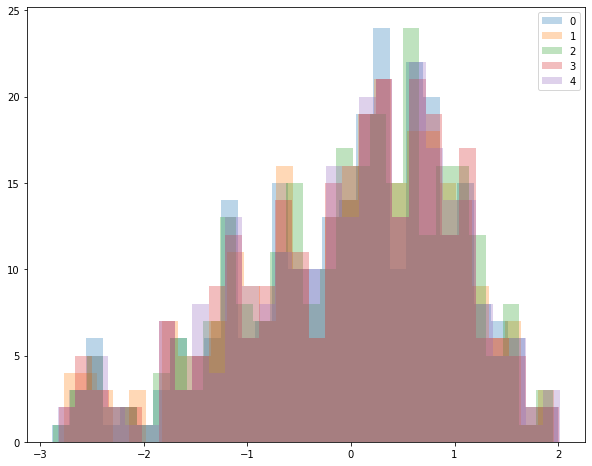

In [119]:
plt.figure(figsize=(10, 8))
for c, pred in enumerate(preds):
    plt.hist(pred[svm_test_inputs['labels'] == 5], bins=30, density=False, alpha=.3, label=f'{c}')
plt.legend() 
plt.show() 

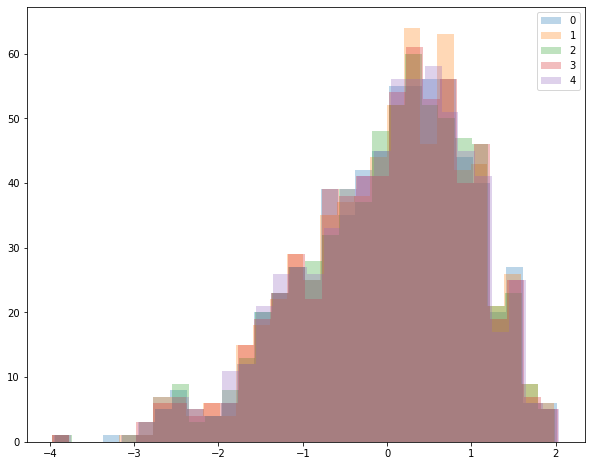

In [120]:
plt.figure(figsize=(10, 8))
for c, pred in enumerate(preds):
    plt.hist(pred, bins=30, density=False, alpha=.3, label=f'{c}')
plt.legend() 
plt.show() 